In [2]:
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# device = "cuda" # the device to load the model onto
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

print("Device: " + device)


Device: cuda


In [3]:
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, Trainer, TrainingArguments, EarlyStoppingCallback

model_name = "distilbert-base-uncased"

model = DistilBertForSequenceClassification.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16 if torch.cuda.is_available() else torch.float32,
    attn_implementation="flash_attention_2"
).to(device)

tokenizer = DistilBertTokenizer.from_pretrained(model_name)

2025-03-13 23:17:47.148214: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/maximilliany/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
You are attempting to use Flash Attention 2.0 with a model not initialized on GPU. Make sure to move the model to GPU after initializing it on CPU with `model.to('cuda')`.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', '

In [4]:
df = pd.read_csv("./dataset/Phishing_Email.csv")
df.head()

df.dropna(inplace=True)

df["label"] = df["Email Type"].apply(lambda x: 1 if x == "Phishing Email" else 0)

In [5]:
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df["Email Text"].tolist(), df["label"].tolist(), test_size=0.2, random_state=42
)

In [6]:
def tokenize(texts):
    return tokenizer(texts, padding="max_length", truncation=True, max_length=512)

In [7]:
train_encodings = tokenize(train_texts)
test_encodings = tokenize(test_texts)

In [8]:
from datasets import Dataset
train_dataset = Dataset.from_dict({
    "input_ids": train_encodings["input_ids"],
    "attention_mask": train_encodings["attention_mask"],
    "labels": train_labels
})

test_dataset = Dataset.from_dict({
    "input_ids": test_encodings["input_ids"],
    "attention_mask": test_encodings["attention_mask"],
    "labels": test_labels
})

In [37]:
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    weight_decay=0.01,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=100,
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=5,
    load_best_model_at_end = True
)

In [38]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)]
)

/home/maximilliany/.local/lib/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [39]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.018400,0.098287
2,0.030600,0.092164
3,0.013000,0.090719
4,0.023800,0.087942
5,0.020200,0.087355
6,0.030000,0.087213
7,0.000000,0.087308
8,0.023500,0.087029
9,0.022200,0.089895
10,0.054400,0.089018


TrainOutput(global_step=24232, training_loss=0.021180985494833174, metrics={'train_runtime': 1021.764, 'train_samples_per_second': 1458.947, 'train_steps_per_second': 182.43, 'total_flos': 2.5670989652944896e+16, 'train_loss': 0.021180985494833174, 'epoch': 13.0})

In [40]:
trainer.evaluate(test_dataset)

{'eval_loss': 0.0870286300778389,
 'eval_runtime': 6.853,
 'eval_samples_per_second': 543.853,
 'eval_steps_per_second': 68.0,
 'epoch': 13.0}

In [41]:
model.save_pretrained("./model")
tokenizer.save_pretrained("./model")

('./model_lr_2e-5/tokenizer_config.json',
 './model_lr_2e-5/special_tokens_map.json',
 './model_lr_2e-5/vocab.txt',
 './model_lr_2e-5/added_tokens.json')

In [42]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

# Get predictions
predictions = trainer.predict(test_dataset)
preds = torch.argmax(torch.tensor(predictions.predictions), axis=1)

# Calculate metrics
accuracy = accuracy_score(test_labels, preds)
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, preds, average="binary")

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Generate a classification report
print(classification_report(test_labels, preds))


Accuracy: 0.9799
Precision: 0.9628
Recall: 0.9888
F1 Score: 0.9756
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      2209
           1       0.96      0.99      0.98      1518

    accuracy                           0.98      3727
   macro avg       0.98      0.98      0.98      3727
weighted avg       0.98      0.98      0.98      3727



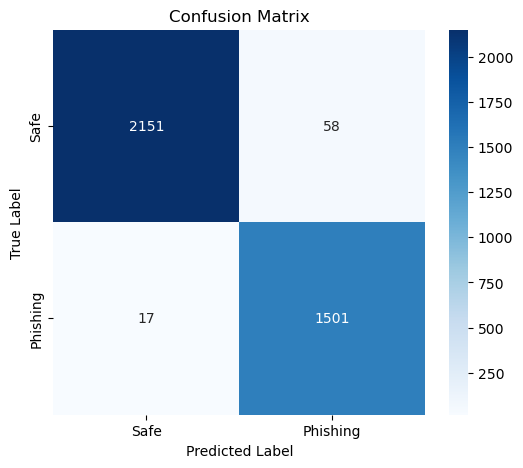

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get predictions
predictions = trainer.predict(test_dataset)
preds = torch.argmax(torch.tensor(predictions.predictions), axis=1)

# Compute confusion matrix
cm = confusion_matrix(test_labels, preds)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Safe", "Phishing"], yticklabels=["Safe", "Phishing"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()